# Setup

Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy.matlib
import numpy as np
import scipy
from scipy.cluster.hierarchy import DisjointSet
from scipy.stats import truncnorm
import math

from network0_def import *
from network1_config import *
# from wk3_2_crit_thres import *
from network2_clustersize import *



Set up 2 configuration model networks for the entire experiments:
1. Poisson degree distribution
2. Geometric degree distribution

In [2]:
# parameters
n = 2048
k_mean = 5 # mean degree

network_p = config_graph_gen(n, deg_dist_poisson(n, k_mean))
network_g = config_graph_gen(n, deg_dist_geo(n, k_mean))

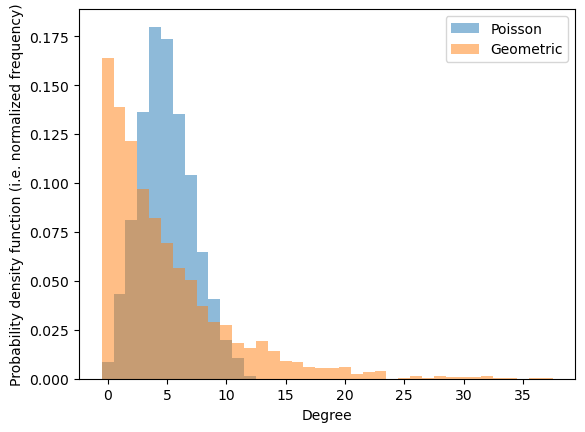

In [3]:
# Plot the degree distribution
plt.figure()
degs_p = network_p.deg_dist()
degs_g = network_g.deg_dist()
plt.hist(degs_p, bins=np.arange(np.max(degs_p))-0.5, density=True, alpha=0.5, label='Poisson')
plt.hist(degs_g, bins=np.arange(np.max(degs_g))-0.5, density=True, alpha=0.5, label='Geometric')
plt.xlabel('Degree')
plt.ylabel('Probability density function (i.e. normalized frequency)')
plt.legend()
plt.show()

In [4]:
edge_ls_p = network_p.edge_list()
edge_ls_g = network_g.edge_list()

# Single deterministic $\lambda$

Set up disease parameters.

In [5]:
lambda_means = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25])
dists = [None, "uniform", "normal", "exponential"]

# Distributions of $\lambda_i$ for individual nodes

Generation of $\lambda_i$ arrays for each given $\lambda$ mean.

In [6]:
def node_lambda(n, mean, dist=None):
    """Generate the susceptibility for each node in the network."""
    # variance scale with mean value
    
    if dist is None:
        lambda_i = np.full(n, mean)
    elif dist == "uniform":
        lambda_i = np.random.uniform(0, 2*mean, n)
    elif dist == "normal":
        std = mean / 3
        lambda_i = np.random.normal(mean, std, n)
        lambda_i = np.clip(lambda_i, 0, 2*mean)
    elif dist == "exponential":
        lambda_i = np.random.exponential(mean, n)
        lambda_i = np.clip(lambda_i, 0, 1) # FIXME: after clipping, the mean is shifted to the left slightly
    else:
        raise ValueError("Invalid distribution type.")
    return lambda_i

def lambda_mat_gen(n, means, dist=None):
    """Generate the susceptibility matrix for each node in the network, for each value of lambda mean."""
    lambda_mat = np.empty((len(means),n))
    for idx, mean in enumerate(means):
        lambda_i = node_lambda(n, mean, dist)
        lambda_mat[idx] = lambda_i

    return lambda_mat # shape (len(means), n)


Set up experiments

In [7]:
lambda_mats = np.empty((len(dists), len(lambda_means), n))
for idx, dist in enumerate(dists):
    lambda_mats[idx] = lambda_mat_gen(n, lambda_means, dist) # shape (len(lambda_means), n)

In [8]:
# Check that the mean is relatively consistent across different distributions
lambda_means_actual = np.mean(lambda_mats, axis=2)
print(lambda_means_actual)

[[0.01       0.02       0.03       0.04       0.05       0.075
  0.1        0.15       0.2        0.25      ]
 [0.01009414 0.0197196  0.03069917 0.03948467 0.05076069 0.07524555
  0.0987004  0.14855622 0.20508094 0.2495049 ]
 [0.00994575 0.01987933 0.03002875 0.04012078 0.04947235 0.0755834
  0.10059605 0.15118324 0.20057015 0.25030994]
 [0.00997492 0.0207977  0.02917093 0.04151535 0.05156939 0.07798207
  0.10025679 0.1482215  0.20570838 0.23771603]]


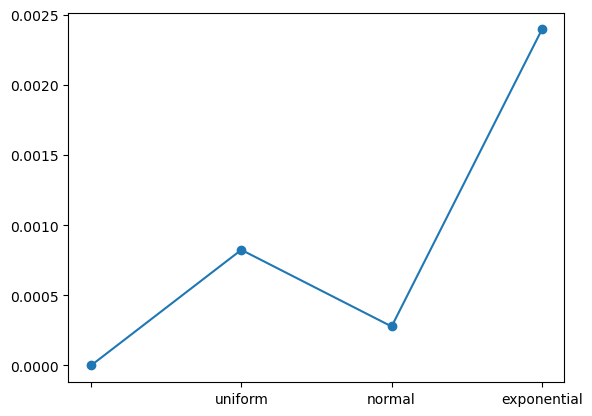

In [9]:
# check variance of each distribution
lambda_var = np.var(lambda_mats, axis=2)
plt.plot(lambda_var[:,4], 'o-')
plt.xticks(range(len(dists)), dists)
plt.show()

Visualising Lambda distribution

[0.05       0.05076069 0.04947235 0.05156939]


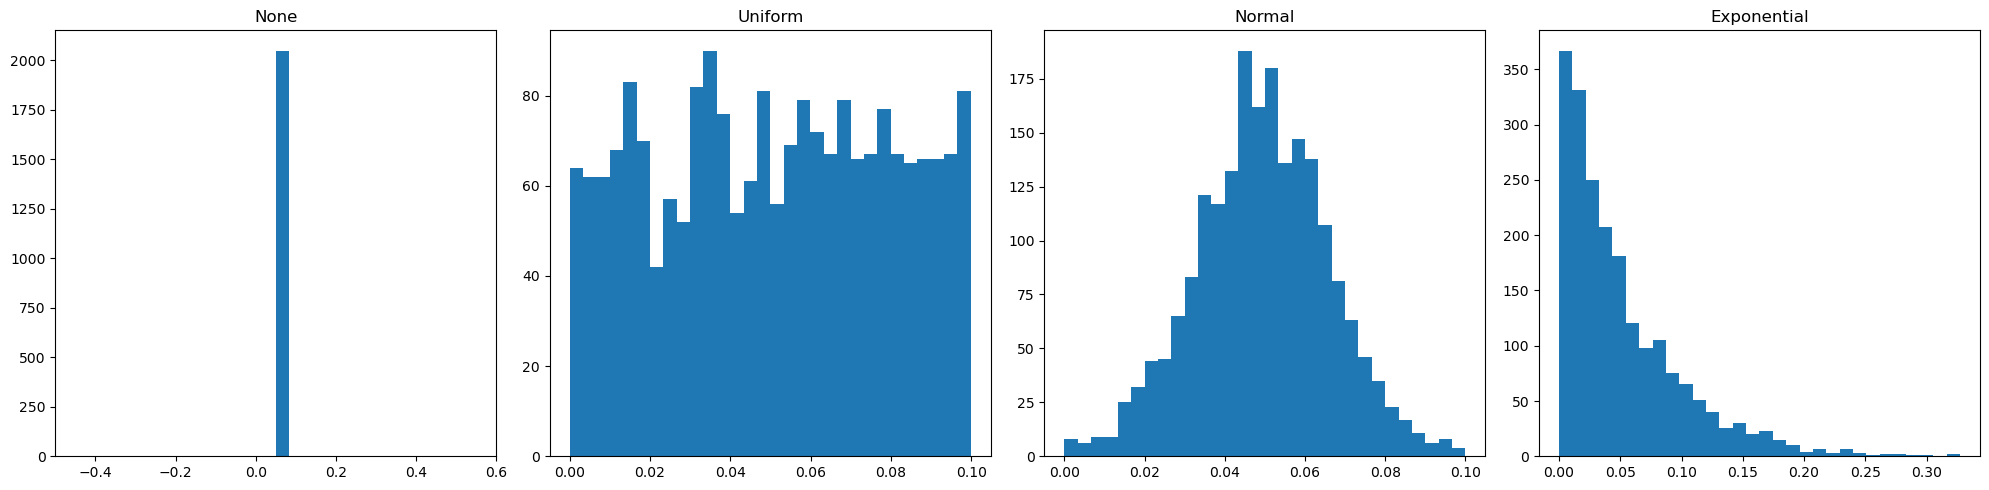

In [10]:
print(lambda_means_actual[:,4])
# Create 1x4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot each histogram in its respective subplot
axes[0].hist(lambda_mats[0, 4, :], bins=30, label = 'None')
axes[0].set_title('None')

axes[1].hist(lambda_mats[1, 4, :], bins=30, label = 'Uniform')
axes[1].set_title('Uniform')

axes[2].hist(lambda_mats[2, 4, :], bins=30, label = 'Normal')
axes[2].set_title('Normal')

axes[3].hist(lambda_mats[3, 4, :], bins=30, label = 'Exponential')
axes[3].set_title('Exponential')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

Empiricals simulations:

In [13]:
output_c_p = np.zeros((len(dists), len(lambda_means)))
output_c_g = np.zeros((len(dists), len(lambda_means)))


for idx1, dist in enumerate(dists): # iterate over different distributions
    print("processing dist: ", dist, "\r")
    if dist is None:
        for idx2, lambda_ in enumerate(lambda_means):
            print("processing lambda: ", lambda_means[idx2], "\r")
            output_c_p[idx1, idx2] = SIR_djset(n, edge_ls_p, lambda_)
            output_c_g[idx1, idx2] = SIR_djset(n, edge_ls_g, lambda_)
            print(f"Dist = {dist}, lambda_mean = {lambda_means[idx2]}, output_p = {output_c_p[idx1, idx2]}, output_g = {output_c_g[idx1, idx2]}")
            
    else:
        lambda_mat = lambda_mats[idx1] # shape (len(lambda_means), n)
        for idx2, lambdas in enumerate(lambda_mat): # iterate over different lambda mean values
            print("processing lambda: ", lambda_means[idx2], "\r")
            output_c_p[idx1, idx2], _ = SIR_djset_dir(n, edge_ls_p, lambdas)
            output_c_g[idx1, idx2], _ = SIR_djset_dir(n, edge_ls_g, lambdas)

            print(f"Dist = {dist}, lambda_mean = {lambda_means[idx2]}, output_p = {output_c_p[idx1, idx2]}, output_g = {output_c_g[idx1, idx2]}")

processing dist:  None 
processing lambda:  0.01 
Dist = None, lambda_mean = 0.01, output_p = 1.0576171875, output_g = 1.048828125
processing lambda:  0.02 
Dist = None, lambda_mean = 0.02, output_p = 1.1240234375, output_g = 1.099609375
processing lambda:  0.03 
Dist = None, lambda_mean = 0.03, output_p = 1.15625, output_g = 1.17578125
processing lambda:  0.04 
Dist = None, lambda_mean = 0.04, output_p = 1.240234375, output_g = 1.29296875
processing lambda:  0.05 
Dist = None, lambda_mean = 0.05, output_p = 1.33203125, output_g = 1.390625
processing lambda:  0.075 
Dist = None, lambda_mean = 0.075, output_p = 1.6689453125, output_g = 1.9560546875
processing lambda:  0.1 
Dist = None, lambda_mean = 0.1, output_p = 2.0302734375, output_g = 4.322265625
processing lambda:  0.15 
Dist = None, lambda_mean = 0.15, output_p = 5.2314453125, output_g = 124.40234375
processing lambda:  0.2 
Dist = None, lambda_mean = 0.2, output_p = 20.525390625, output_g = 243.0517578125
processing lambda:  0.2

In [15]:
'''output_c_p = [[1.05761719e+00 1.12402344e+00 1.15625000e+00 1.24023438e+00
  1.33203125e+00 1.66894531e+00 2.03027344e+00 5.23144531e+00
  2.05253906e+01 1.37926758e+02]
 [9.70000000e+01 1.90000000e+02 2.90000000e+02 3.51000000e+02
  4.54000000e+02 6.29000000e+02 7.50000000e+02 9.50000000e+02
  1.14400000e+03 1.25500000e+03]
 [1.20000000e+02 1.95000000e+02 3.07000000e+02 3.65000000e+02
  4.68000000e+02 6.55000000e+02 7.87000000e+02 1.03300000e+03
  1.24600000e+03 1.38600000e+03]
 [9.10000000e+01 2.05000000e+02 2.71000000e+02 3.41000000e+02
  4.33000000e+02 5.59000000e+02 6.86000000e+02 8.89000000e+02
  1.03100000e+03 1.08200000e+03]]'''


'''output_c_g = [[1.04882812e+00 1.09960938e+00 1.17578125e+00 1.29296875e+00
  1.39062500e+00 1.95605469e+00 4.32226562e+00 1.24402344e+02
  2.43051758e+02 4.54482422e+02]
 [1.00000000e+02 1.62000000e+02 2.52000000e+02 3.23000000e+02
  4.00000000e+02 5.03000000e+02 6.30000000e+02 7.74000000e+02
  9.38000000e+02 9.79000000e+02]
 [8.30000000e+01 1.89000000e+02 2.35000000e+02 3.21000000e+02
  3.87000000e+02 5.46000000e+02 6.68000000e+02 8.67000000e+02
  9.77000000e+02 1.08800000e+03]
 [8.70000000e+01 1.91000000e+02 2.34000000e+02 2.94000000e+02
  3.75000000e+02 4.85000000e+02 5.74000000e+02 7.28000000e+02
  8.08000000e+02 9.21000000e+02]]'''

[[1.05761719e+00 1.12402344e+00 1.15625000e+00 1.24023438e+00
  1.33203125e+00 1.66894531e+00 2.03027344e+00 5.23144531e+00
  2.05253906e+01 1.37926758e+02]
 [9.70000000e+01 1.90000000e+02 2.90000000e+02 3.51000000e+02
  4.54000000e+02 6.29000000e+02 7.50000000e+02 9.50000000e+02
  1.14400000e+03 1.25500000e+03]
 [1.20000000e+02 1.95000000e+02 3.07000000e+02 3.65000000e+02
  4.68000000e+02 6.55000000e+02 7.87000000e+02 1.03300000e+03
  1.24600000e+03 1.38600000e+03]
 [9.10000000e+01 2.05000000e+02 2.71000000e+02 3.41000000e+02
  4.33000000e+02 5.59000000e+02 6.86000000e+02 8.89000000e+02
  1.03100000e+03 1.08200000e+03]]
[[1.04882812e+00 1.09960938e+00 1.17578125e+00 1.29296875e+00
  1.39062500e+00 1.95605469e+00 4.32226562e+00 1.24402344e+02
  2.43051758e+02 4.54482422e+02]
 [1.00000000e+02 1.62000000e+02 2.52000000e+02 3.23000000e+02
  4.00000000e+02 5.03000000e+02 6.30000000e+02 7.74000000e+02
  9.38000000e+02 9.79000000e+02]
 [8.30000000e+01 1.89000000e+02 2.35000000e+02 3.21000000

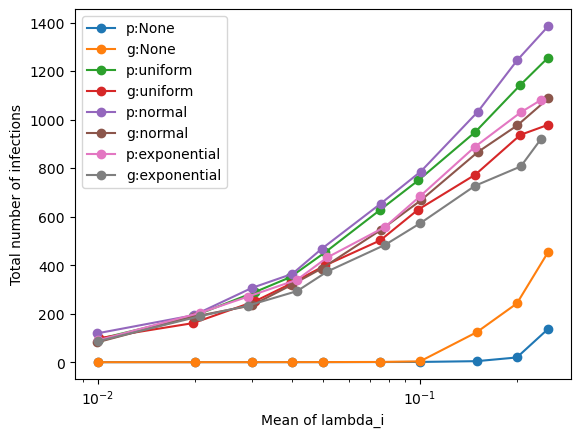

In [14]:
# plot
plt.figure()
for idx, dist in enumerate(dists):
    plt.plot(lambda_means_actual[idx], output_c_p[idx], 'o-', label=f"p:{dist}")
    plt.plot(lambda_means_actual[idx], output_c_g[idx], 'o-', label=f"g:{dist}")
plt.xlabel("Mean of lambda_i")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()

# Mask wearing
Introducing infection weights $w_s$, $w_i$, $w_d$

Let $p_m$ demote percentage of people wearing masks. <br>
Assume a constant $\lambda$ = 0.4. i.e. None distribution

In [ ]:
# Setup
n = 10000
mean = 20
pm_ary = np.array([0.1, 0.5, 0.8])
lambda_ary = np.linspace(0.0, 0.3, 31)
iter_n = 100

In [ ]:
# Run the simulation without mask (original spread)
Nr_ary_nomask = np.zeros(len(lambda_ary))
Nr_covs_nomask = np.zeros(len(lambda_ary))

# Generate one single network and calculate the number of total infections for each lambda
for idx, lambda_ in enumerate(lambda_ary):
    print("processing lambda: ", lambda_)
    edge_ls = np.random.permutation(edge_ls) # Shuffle the edge list along the edge pair axis
    cluster_size = np.zeros(iter_n)
    for itn in range(iter_n):
        print("iter: ", itn, '/', iter_n, end='\r')
        cluster_size[itn] = SIR_djset(n, edge_ls, lambda_)
    mu = np.mean(cluster_size)
    Nr_ary_nomask[idx] = mu
    Nr_covs_nomask[idx] = np.std(cluster_size) / mu

The reduction in infection probability towards a susceptible person wearing masks be $w_s$ = 50%;<br>
The reduction in infection probability from an infectious person wearing masks be $w_i$ = 50%;<br>
The reduction in infection probability for both people wearing masks be $w_b$ = 80%.

In [ ]:
w_s = 0.5 # only susceptible node wearing mask
w_i = 0.5 # only infected node wearing mask
w_b = 0.2 # both susceptible and infected nodes wearing mask 1-0.8 = 0.2
w = np.array([w_s, w_i, w_b])

In [ ]:
def SIR_djset_mask(n, edge_ls, lambda_, pm, w):
    """Simulate the SIR model on the given network represented by disjoint set.
    Assume single seed node to be node 0.
    Giving the mask wearing probability for each node."""
    w_s, w_i, w_b = w

    # For a randomly chosen edge, probability of the 3 cases:
    pm_neither = (1-pm)**2 # neither of the nodes are wearing masks --> *1.0
    pm_single = 2*pm*(1-pm) # only 1 node is wearing mask #FIXME: how to determine if it's the source or sink node?? --> *w_s or *w_i
    pm_both = pm**2 # both nodes are wearing masks --> *w_b

    prob = np.array([pm_neither, pm_single/2, pm_single/2, pm_both]) # FIXME: Assume an edge has equal proability of being either direction
    weights = np.array([1.0, w_s, w_i, w_b])

    # For each edge, randomly choose a case based on the probability distribution
    lambdas_weighted = np.random.choice(weights, size=edge_ls.shape[0], p=prob) * lambda_
    # print(lambdas_weighted[:20])



    C = DisjointSet(range(n))
    
    prob_infect = np.random.binomial(1, p=lambdas_weighted) # Randomly assign infection outcome to each edge based on probability weighted lambda_i
    
    for idx, edge in enumerate(edge_ls):
        if prob_infect[idx] == 1:
            C.merge(edge[0], edge[1])

    return C.subset_size(0) # Assume node 0 is the seed node

In [ ]:
# Simulations with mask
Nr_arys_mask = np.zeros((len(pm_ary), len(lambda_ary)))
Nr_covs_mask = np.zeros((len(pm_ary), len(lambda_ary)))


edge_ls = config_graph_edge_ls(n, deg_dist_poisson(n, mean))
for idx1, pm in enumerate(pm_ary):
    print("processing mask wearing proportion: ", pm)


    for idx2, lambda_ in enumerate(lambda_ary):
        print("processing lambda: ", lambda_)
        cluster_size = np.zeros(iter_n)

        for itn in range(iter_n):
            print("iter: ", itn, '/', iter_n, end='\r')
            edge_ls = np.random.permutation(edge_ls) # Shuffle the edge list along the edge pair axis
            cluster_size[itn] = SIR_djset_mask(n, edge_ls, lambda_, pm, w)
        mu = np.mean(cluster_size)
        Nr_arys_mask[idx1,idx2] = mu
        Nr_covs_mask[idx1,idx2] = np.std(cluster_size) / mu

        print(f"mask proportion = {pm}, lambda = {lambda_}, Nr = {mu}")

In [ ]:
# Data store 3:
'''Nr_ary_nomask = [1.00000e+00 1.27000e+00 1.67000e+00 2.42000e+00 4.60000e+00 5.26500e+01
 9.42980e+02 2.27835e+03 4.20314e+03 5.37899e+03 6.71242e+03 7.18865e+03
 7.83659e+03 8.51820e+03 9.06586e+03 9.31269e+03 9.24259e+03 9.43120e+03
 9.50364e+03 9.56494e+03 9.51044e+03 9.74249e+03 9.86891e+03 9.89386e+03
 9.91607e+03 9.93115e+03 9.94320e+03 9.95418e+03 9.96239e+03 9.96867e+03
 9.97464e+03]'''

'''Nr_arys_mask = [[1.00000e+00 1.22000e+00 1.62000e+00 2.52000e+00 3.24000e+00 7.37000e+00
  2.92020e+02 1.48169e+03 2.81346e+03 4.76383e+03 4.94033e+03 6.75778e+03
  7.37751e+03 8.19138e+03 8.25556e+03 8.80741e+03 9.23528e+03 8.88950e+03
  9.07407e+03 9.25002e+03 9.60029e+03 9.65767e+03 9.50270e+03 9.73434e+03
  9.66373e+03 9.88378e+03 9.90311e+03 9.92011e+03 9.93380e+03 9.94576e+03
  9.95413e+03]
 [1.00000e+00 1.11000e+00 1.28000e+00 1.66000e+00 1.80000e+00 2.39000e+00
  2.80000e+00 4.30000e+00 4.64000e+00 1.75300e+01 2.88740e+02 1.23595e+03
  1.99601e+03 2.91367e+03 4.35463e+03 4.50120e+03 5.32222e+03 6.23735e+03
  6.59510e+03 7.07123e+03 7.53019e+03 7.80705e+03 8.03494e+03 8.16645e+03
  8.20185e+03 8.93780e+03 8.84053e+03 8.64102e+03 9.17940e+03 9.23943e+03
  9.48490e+03]
 [1.00000e+00 1.05000e+00 1.11000e+00 1.42000e+00 1.55000e+00 1.26000e+00
  1.80000e+00 1.85000e+00 1.92000e+00 2.70000e+00 2.78000e+00 3.60000e+00
  4.52000e+00 6.87000e+00 8.30000e+00 3.16000e+01 1.34790e+02 3.14960e+02
  8.18040e+02 1.77144e+03 1.81942e+03 2.30825e+03 3.84023e+03 3.85305e+03
  4.66982e+03 4.13071e+03 5.29750e+03 4.93189e+03 5.53855e+03 5.85795e+03
  6.24653e+03]]'''


Theoretical Effect: As if shift mean of lambda by mean[pm_prob] = [0.902, 0.55, 0.328]* lambda

In [ ]:

lambda_ary_eff = np.zeros((len(pm_ary), len(lambda_ary)))
for idx,pm in enumerate(pm_ary):
    pm_neither = (1-pm)**2 # neither of the nodes are wearing masks --> *1.0
    pm_single = 2*pm*(1-pm) # only 1 node is wearing mask 
    pm_both = pm**2 # both nodes are wearing masks --> *w_b

    prob = np.array([pm_neither, pm_single/2, pm_single/2, pm_both]) 
    weights = np.array([1.0, w_s, w_i, w_b])

    lambda_shiftfactor = np.mean(np.dot(prob, weights)) # [0.902, 0.55, 0.328]
    print(f'pm = {pm}:, lambda is effectively factored by {lambda_shiftfactor}')

    lambda_ary_eff[idx] = lambda_ary / lambda_shiftfactor # effective lambda for each mask wearing proportion


In [ ]:
plt.figure()
color_scheme = ['tab:blue', 'tab:orange', 'tab:green']

for idx, pm in enumerate(pm_ary):
    plt.plot(lambda_ary_eff[idx], Nr_ary_nomask, '--', color = color_scheme[idx], label=f"pm={pm}")
    plt.plot(lambda_ary, Nr_arys_mask[idx], 'o-', color = color_scheme[idx])
plt.plot(lambda_ary, Nr_ary_nomask, 'o-', color = 'tab:red', label="no mask")
plt.xlabel("Lambda_i")
plt.xscale("log")
plt.ylabel("Total number of infections")
plt.legend()
plt.show()